<a href="https://colab.research.google.com/github/Shailja1310/Hotel_Recommendation_System_Expedia/blob/master/Hotel_recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connecting to kaggle to load the dataset

In [ ]:
!pip install -q kaggle
!mkdir .kaggle
#!mkdir -p ~/.kaggle
import json
token = {"username":"<username>","key":"<your_key>"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    !kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


Download the dataset

In [ ]:
!kaggle competitions download -c expedia-hotel-recommendations -p /content

 99% 580M/584M [00:26<00:00, 16.0MB/s]
100% 584M/584M [00:26<00:00, 23.2MB/s]
 98% 76.0M/77.4M [00:03<00:00, 23.1MB/s]
100% 77.4M/77.4M [00:03<00:00, 24.8MB/s]
  0% 0.00/5.67M [00:00<?, ?B/s]
100% 5.67M/5.67M [00:00<00:00, 52.1MB/s]
 87% 17.0M/19.5M [00:00<00:00, 17.7MB/s]
100% 19.5M/19.5M [00:00<00:00, 23.6MB/s]


In [ ]:
!unzip \*.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  destinations.csv.zip
  inflating: destinations.csv        

4 archives were successfully processed.


Install Required Libraries

In [ ]:
!pip install ml_metrics
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import ml_metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=05dc90d420c7873c5eff2fb81a60254112749f021511dde143b52657e225772d
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


**data visualisation**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


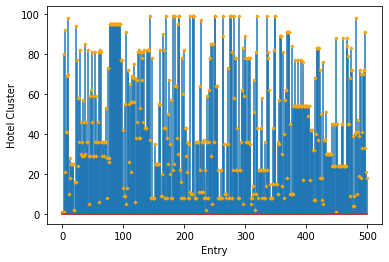

In [ ]:
import matplotlib.pyplot as plt
df1=pd.read_csv('train.csv', nrows=500)
df1.head()
(markers, stemlines, baseline) = plt.stem(df1.hotel_cluster)
plt.setp(markers, marker='D', markersize=1, markeredgecolor="orange", markeredgewidth=2)
plt.xlabel('Entry')
plt.ylabel('Hotel Cluster')
plt.show()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


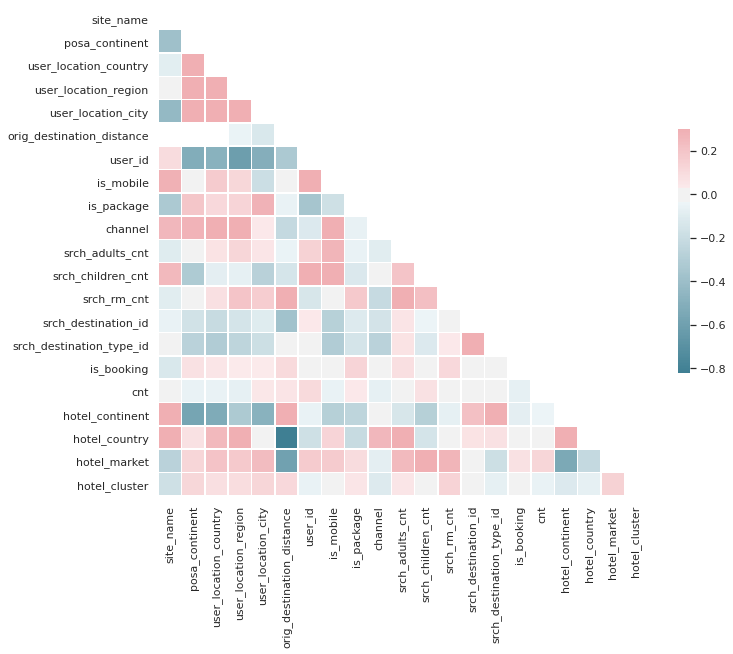

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

#compute Correlation matrix
corr = df1.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap,mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Data Pre-Processing

In [ ]:
import pandas as pd
import numpy as np
dtype={'is_booking':bool,
        'srch_ci' : np.str_,
        'srch_co' : np.str_,
        'srch_adults_cnt' : np.int32,
        'srch_children_cnt' : np.int32,
        'srch_rm_cnt' : np.int32,
        'srch_destination_id':np.int64,
        'hotel_cluster' : np.int64,
        'date_time':np.int64,
        'hotel_market':np.int64}

In [ ]:
df0 = pd.read_csv('train.csv',dtype=dtype,usecols=dtype, parse_dates=['date_time'] ,sep=',',nrows=200000)
df0.head()


,date_time,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,is_booking,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2014-08-27,2014-08-31,2,0,1,8250,False,628,1
1,2014-08-11 08:22:12,2014-08-29,2014-09-02,2,0,1,8250,True,628,1
2,2014-08-11 08:24:33,2014-08-29,2014-09-02,2,0,1,8250,False,628,1
3,2014-08-09 18:05:16,2014-11-23,2014-11-28,2,0,1,14984,False,1457,80
4,2014-08-09 18:08:18,2014-11-23,2014-11-28,2,0,1,14984,False,1457,21


In [ ]:
# take data from 2014 as sampling 50%
df0['year']=df0['date_time'].dt.year
train = df0.query('is_booking==True' )#& year==2013')
train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')

train['month']= train['date_time'].dt.month
train['plan_time'] = ((train['srch_ci']-train['date_time'])/np.timedelta64(1,'D')).astype(float)
train['hotel_nights']=((train['srch_co']-train['srch_ci'])/np.timedelta64(1,'D')).astype(float)
train.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

(16669, 14)

In [ ]:
y=train['hotel_cluster']
X=train.drop(['hotel_cluster','is_booking','year','month','date_time','srch_ci','srch_co'],axis=1) # in training dataset, have clicking and booking event
X.head()

,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,hotel_market,plan_time,hotel_nights
1,2,0,1,8250,628,17.651250,4.0
20,2,0,1,8291,191,49.248935,2.0
27,2,0,1,1385,185,82.348553,8.0
72,2,0,1,8803,69,214.248380,2.0
79,3,0,2,12009,680,49.312303,5.0


In [ ]:
y.head()

1      1
20     2
27    58
72    36
79    95
Name: hotel_cluster, dtype: int64

Splitting into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13335, 7), (3334, 7), (13335,), (3334,))

Building Model_KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k_range = range(1,20)
scores={}
scores_list=[]
for k in k_range:
  knn_test=KNeighborsClassifier(n_neighbors=k)
  knn_test.fit(X_train,y_train)
  yhat_knn_test=knn_test.predict(X_test)
  scores[k]=metrics.accuracy_score(y_test,yhat_knn_test)
  scores_list.append(metrics.accuracy_score(y_test,yhat_knn_test))


Text(0, 0.5, 'testing accuracy')

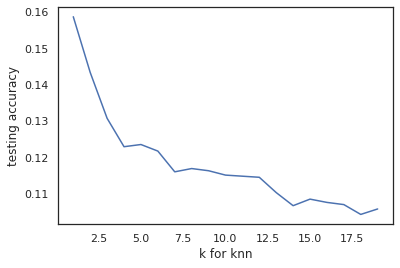

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range,scores_list)
plt.xlabel('k for knn')
plt.ylabel('testing accuracy')

In [ ]:
#Final KNN Model
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
yhat_knn=knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, yhat_knn)
print("Accuracy: %.2f%%" % (accuracy_knn * 100.0))

Accuracy: 11.61%


**Building Model-------XGBoost**






In [ ]:
!pip install XGBoost

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier

In [ ]:

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 12.93%


**Ada boost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
#X, y = make_classification(n_samples = 1000, n_features = 10,n_informative = 2, n_redundant = 0,random_state = 0, shuffle = False)
ADBclf = AdaBoostClassifier(n_estimators = 100, random_state = 0)
ADBclf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
yhat_ada=ADBclf.predict(X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, yhat_ada)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 5.70%


**`gradient tree boosting`**

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
GDBclf = GradientBoostingClassifier(n_estimators = 50, learning_rate = 1.0,max_depth = 1, random_state = 0).fit(X_train, y_train)
GDBclf.score(X_test, y_test)

0.015896820635872826

In [ ]:
yhat_GBTree=ADBclf.predict(X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, yhat_GBTree)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 5.70%


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_tree.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=31,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
y_pred=rf_tree.predict_proba(X_test) # predict on test dataset
a=y_pred.argsort(axis=1)[:,-1:]
a

array([[ 1],
       [40],
       [91],
       ...,
       [30],
       [59],
       [91]])

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, a)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 12.15%


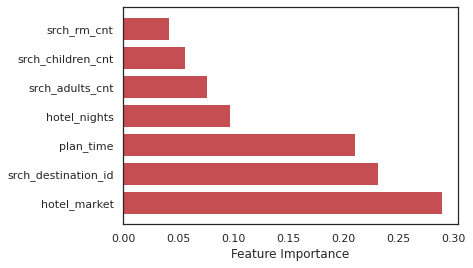

In [ ]:
#feature importance
importance = rf_tree.feature_importances_
indices=np.argsort(importance)[::-1][:7]
importance[indices]

plt.barh(range(7), importance[indices],color='r')
plt.yticks(range(7),X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

**Naive_bayes**


In [ ]:
def to_categorical_plan_time(column_list=[]):
  new_list=[]
  for x in column_list:
    if (x<50.0):
      new_list.append(0)
    elif (x>50.0 and x<100.0):
      new_list.append(1)
    elif (x>100.0 and x<150.0):
      new_list.append(2)
    else:
      new_list.append(3)
  return new_list

In [ ]:
X.head()

,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,hotel_market,plan_time,hotel_nights
1,2,0,1,8250,628,17.651250,4.0
20,2,0,1,8291,191,49.248935,2.0
27,2,0,1,1385,185,82.348553,8.0
72,2,0,1,8803,69,214.248380,2.0
79,3,0,2,12009,680,49.312303,5.0


In [ ]:
X['categorical_plan_time']=to_categorical_plan_time(X['plan_time'].tolist())
print(X['categorical_plan_time'])

1         0
20        0
27        1
72        3
79        0
         ..
199961    0
199965    0
199970    0
199984    0
199996    0
Name: categorical_plan_time, Length: 16669, dtype: int64


In [ ]:
X_trainNB, X_testNB, y_trainNB, y_testNB = train_test_split(X,y, test_size=0.20)
print(X_train.head(),y_train.head())

        srch_adults_cnt  srch_children_cnt  ...  plan_time  hotel_nights
26830                 1                  0  ...   6.641192           2.0
146318                1                  0  ...   5.769560           2.0
146945                1                  0  ...   0.300799           1.0
87540                 2                  0  ...  11.456169           2.0
193543                1                  0  ...  19.525139           1.0

[5 rows x 7 columns] 26830      6
146318    82
146945    23
87540     28
193543    50
Name: hotel_cluster, dtype: int64


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
model=GaussianNB()
model.fit(X_train,y_train)
yhat_NB=model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, yhat_NB)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 4.95%


**MODEL_____SVM**

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
yhat_SVM = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, yhat_SVM)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 4.14%


**Building Ensemble-1 : Stacking**

In [ ]:
level0 = list()
level0.append(('XGB', XGBClassifier()))
level0.append(('knn', KNeighborsClassifier(n_neighbors=2)))
level0.append(('bayes', GaussianNB()))

In [ ]:
level1 = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)

In [ ]:
from sklearn.ensemble import StackingClassifier
model_f = StackingClassifier(estimators=level0, final_estimator =level1, cv=5)
model_f.fit(X_train, y_train)
yhat_f = model_f.predict(X_test)
accuracy = accuracy_score(y_test, yhat_f)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 11.40%


### **SAMPLE INPUT**

In [ ]:
 inputt={}
 inputt['srch_adults_cnt']=2 #Number of adults
 inputt['srch_children_cnt']=3 #number of children
 inputt['srch_rm_cnt']=1 #No. of rooms
 inputt['srch_destination_id']=8250 # Destination of Stay
 inputt['hotel_market']=325 # Hotel Market
 inputt['plan_time']=17.65 # Total Plan Time
 inputt['hotel_nights']=2.0 # Number of nights of stay
 df_check=pd.DataFrame(inputt,index=[0])


**SAMPLE OUTPUT : Ensemble 1**

In [ ]:
 print('Predicted Hotel cluster :',model_f.predict(df_check))

Predicted Hotel cluster : [91]


In [ ]:
def CountFrequency(my_list): 
      
    # Creating an empty dictionary  
    freq = {} 
    for items in my_list: 
        freq[items] = my_list.count(items) 
      
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 

**Buliding----Ensemble-2 : Max-Voting**

In [ ]:
import numpy as np
import time

time_tot=time.clock()
def Ensemble_2(input_data):
  print('********** Ensemble 2 Running ********\n')
  freq={}
  final_arr=[]

  time_start = time.clock()
  print('********** Random Forest Classifier Running ********\t')
  model_1 = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)#first Model : random Forest
  rf_tree.fit(X_train,y_train)
  y_pred=rf_tree.predict_proba(input_data) # predict on test dataset
  a=y_pred.argsort(axis=1)[:,-5:] #get the top 5 probabilities
  for i in range(0,len(a)):#append that into our final array
    for j in range(0,len(a[i])):
      final_arr.append(a[i][j])
  print('Computational time :', (time.clock()-time_start),'\n')

  time_start = time.clock()
  print('********** KNN Running ********\t')
  model_2=KNeighborsClassifier(n_neighbors=2)# Model 2 KNN
  model_2.fit(X_train,y_train)
  final_arr.append(model_2.predict(input_data)[0])#append the result to final array
  print('Computational time :', (time.clock()-time_start),'\n')
  
  time_start = time.clock()
  print('********* XGB running *********\t')
  model_3=XGBClassifier()# Model 3 XGBoost
  model_3.fit(X_train,y_train)
  final_arr.append(model_3.predict(input_data)[0])#append the result to final array
  print('Computational time :', (time.clock()-time_start),'\n')
  
  time_start = time.clock()
  print('********** Ada_Boost Running ********\t')
  model_4=AdaBoostClassifier(n_estimators = 100, random_state = 0)# Model 4 Ada-Boost
  model_4.fit(X_train,y_train)
  final_arr.append(model_4.predict(input_data)[0])#append the result to final array
  print('Computational time :', (time.clock()-time_start),'\n')
  
  #time_start = time.clock()
  #print('********** Gradient Boost Running ********\t')
  #model_5=GradientBoostingClassifier(n_estimators = 50, learning_rate = 1.0,max_depth = 1, random_state = 0)# Model 5 GB tree 
  #model_5.fit(X_train,y_train)
  #final_arr.append(model_5.predict(input_data)[0])#append the result to final array
  #print('Computational time :', (time.clock()-time_start),'\n')
  
  time_start = time.clock()
  print('********** Naive Bayes Running ********\t')
  model_6=GaussianNB()# Model 6 Naive Bayes
  model_6.fit(X_train,y_train)
  final_arr.append(model_6.predict(input_data)[0])#append the result to final array
  print('Computational time :', (time.clock()-time_start),'\n')
  
  time_start = time.clock()
  print('********** SVM Running ********\t')
  model_7=svm.SVC(kernel='rbf')# Model 7 SVM
  model_7.fit(X_train,y_train)
  final_arr.append(model_7.predict(input_data)[0])#append the result to final array
  print('Computational time :', (time.clock()-time_start),'\n')
 
  #time_start = time.clock()
  #print('********** Ensemble-1 Running ********\t')
  #model_8=StackingClassifier(estimators=level0, final_estimator =level1, cv=5)# Model 8 Ensemble-1
  #model_8.fit(X_train,y_train)
  #final_arr.append(model_8.predict(input_data)[0])#append the result to final array
  #print('Computational time :', (time.clock()-time_start),'\n')
  

  #print('\n Final Array:',final_arr)
  #print('\n')


  #calculate frequency of each prediction
  def Count_Frequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    return freq
  
  freq=Count_Frequency(final_arr)
  #print('\nFrequency of predicted classes : ',freq)

  #get max frequency element
  def get_max_freq(freq):
    c=0
    max_ele=0
    for key in freq:
      if (freq[key]>c) :
        max_ele=key
        c=freq[key]
    del freq[max_ele]
    return max_ele
  print('\nEnsemble 2 Computational time :', (time.clock()-time_tot),'\n')
  #print the top 5 predictions
  print('\nSuggested Hotel Clusters for you are :','\t')
  for k in range(0,5):
    print(get_max_freq(freq),end=" ")


**SAMPLE OUTPUT WITH ENSEMBLE 2**

In [ ]:
Ensemble_2(df_check)

********** Ensemble 2 Running ********

********** Random Forest Classifier Running ********	
Computational time : 0.6452709999999797 

********** KNN Running ********	
Computational time : 0.01806900000008227 

********* XGB running *********	
Computational time : 51.850668999999925 

********** Ada_Boost Running ********	
Computational time : 5.726658999999927 

********** Naive Bayes Running ********	
Computational time : 0.02054899999995996 

********** SVM Running ********	
Computational time : 15.329791999999998 


Ensemble 2 Computational time : 73.601227 


Suggested Hotel Clusters for you are : 	
91 82 15 46 47 